<a href="https://colab.research.google.com/github/Ann-Krlv/BI_ML_2021/blob/HW7-8_fc_nn/FC_NN/FC_NN_practice_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

По идее, чем больше размер батча, тем быстрее происходит обучение. Т.е., наверное, было бы круто иметь бесконечные ресурсы и вообще не делить данные на батчи, а так приходится брать какой-то адекватно большой размер

Посмотрим на какую-нибудь картинку:

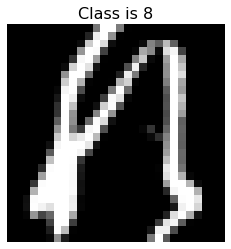

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿<br>
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿<br>
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿<br>
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹<br>
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧<br>
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰<br>
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿<br>
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿<br>
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿<br>
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿<br>
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿<br>
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿<br>
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿<br>
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿<br>


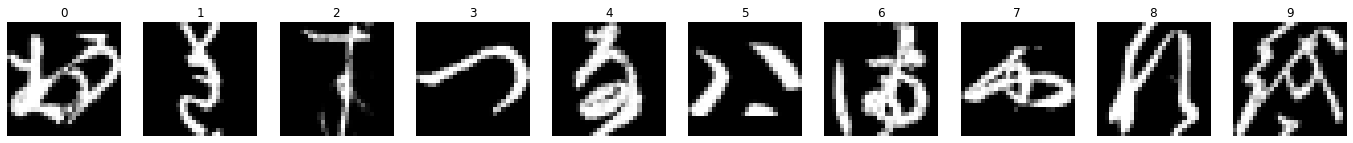

In [ ]:
plt.rcParams["figure.figsize"] = 24, 13
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    for pct in trainset:
      if pct[1] == i:
        pixels = pct[0].view(28, 28).numpy()
        plt.imshow(pixels, cmap='gray')
        plt.title(pct[1])
        plt.axis("off")
        break
plt.rcParams["figure.figsize"] = 6.4, 4.8

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.act = nn.ReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        logits = self.fc3(x)
        # после последнего слоя активация не нужна, т.к. дальше CrossEntropyLoss захочет raw logits

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**  235146

In [ ]:
net = FCNet()
ans = 0
for param in net.parameters():
    ans += len(param.view(-1))
ans

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10

## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f"Epoch={epoch+1} loss={epoch_loss/len(trainloader):.4f}")

Epoch=1 loss=0.9181
Epoch=2 loss=0.4394
Epoch=3 loss=0.3460
Epoch=4 loss=0.2934
Epoch=5 loss=0.2525
Epoch=6 loss=0.2210
Epoch=7 loss=0.1921
Epoch=8 loss=0.1697
Epoch=9 loss=0.1497
Epoch=10 loss=0.1317


In [ ]:
get_accuracy(fc_net, testloader)

0.875

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = torch.mean(trainset.data.to(torch.float32), dim=(0, 1, 2)) / 255 ## calculate mean
std = torch.std(trainset.data.to(torch.float32), dim=(0, 1, 2)) / 255 ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f"Epoch={epoch+1} loss={epoch_loss/len(trainloader):.4f}")

Epoch=1 loss=0.6907
Epoch=2 loss=0.3045
Epoch=3 loss=0.2230
Epoch=4 loss=0.1735
Epoch=5 loss=0.1384
Epoch=6 loss=0.1120
Epoch=7 loss=0.0921
Epoch=8 loss=0.0754
Epoch=9 loss=0.0607
Epoch=10 loss=0.0495


In [ ]:
get_accuracy(fc_net, testloader)

0.8957

Как изменилась `accuracy` после нормализации?

*Немного выросло*

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
class FCNet_act(nn.Module):
    def __init__(self, act_fun):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.act = act_fun()

    def forward(self, x):  
        ## x -> tensor(BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        logits = self.fc3(x)

        return logits

In [ ]:
loss_function = nn.CrossEntropyLoss()
lr = 0.001

In [ ]:
n_epochs = 10
loss_history = [[], [], [], []]
func = [nn.ReLU, nn.Sigmoid, nn.GELU, nn.Tanh]

## YOUR CODE HERE
for i in range(0, 4):
  print(f'{func[i].__name__}')
  fc_net_act = FCNet_act(func[i])
  optimizer = torch.optim.Adam(fc_net_act.parameters(), lr=3e-4)
  for epoch in range(n_epochs):
      epoch_loss = 0
      for images, labels in trainloader: 
          optimizer.zero_grad() 
          outputs = fc_net_act(images) 
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()

      loss_history[i].append(epoch_loss/len(trainloader))
      print(f"Epoch={epoch+1} loss={loss_history[i][epoch]:.4f}")

  print(f'accuracy with {func[i].__name__}', get_accuracy(fc_net_act, testloader))

ReLU
Epoch=1 loss=0.6826
Epoch=2 loss=0.3056
Epoch=3 loss=0.2241
Epoch=4 loss=0.1736
Epoch=5 loss=0.1389
Epoch=6 loss=0.1124
Epoch=7 loss=0.0921
Epoch=8 loss=0.0765
Epoch=9 loss=0.0625
Epoch=10 loss=0.0510
accuracy with ReLU 0.8986
Sigmoid
Epoch=1 loss=1.5554
Epoch=2 loss=0.7517
Epoch=3 loss=0.5461
Epoch=4 loss=0.4480
Epoch=5 loss=0.3784
Epoch=6 loss=0.3243
Epoch=7 loss=0.2804
Epoch=8 loss=0.2445
Epoch=9 loss=0.2145
Epoch=10 loss=0.1898
accuracy with Sigmoid 0.8567
GELU
Epoch=1 loss=0.6676
Epoch=2 loss=0.2787
Epoch=3 loss=0.2019
Epoch=4 loss=0.1545
Epoch=5 loss=0.1212
Epoch=6 loss=0.0981
Epoch=7 loss=0.0786
Epoch=8 loss=0.0636
Epoch=9 loss=0.0506
Epoch=10 loss=0.0393
accuracy with GELU 0.9005
Tanh
Epoch=1 loss=0.7683
Epoch=2 loss=0.3788
Epoch=3 loss=0.2553
Epoch=4 loss=0.1827
Epoch=5 loss=0.1364
Epoch=6 loss=0.1022
Epoch=7 loss=0.0763
Epoch=8 loss=0.0572
Epoch=9 loss=0.0419
Epoch=10 loss=0.0309
accuracy with Tanh 0.894


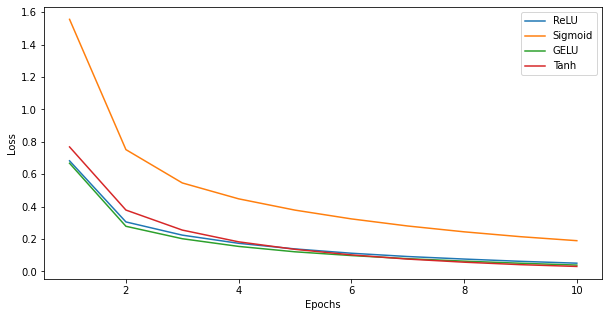

In [ ]:
plt.figure(figsize=(10,5))
for i in range(4):
  plt.plot([i+1 for i in range(n_epochs)], loss_history[i], label=func[i].__name__)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

`GELU` 

хотя, если запускать нескольуо раз, можно скзать только, что худший результат даёт сигмоида (что логично)

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
from torch.optim import Adam, RMSprop, Adagrad
n_epochs = 10
loss_history = [[], [], []]
opt_func = [Adam, RMSprop, Adagrad]

## YOUR CODE HERE
for i in range(0, 3):
  print(opt_func[i].__name__)
  fc_net_opt = FCNet_act(nn.GELU)
  optimizer = opt_func[i](fc_net_opt.parameters(), lr=3e-4)
  for epoch in range(n_epochs):
      epoch_loss = 0
      for images, labels in trainloader: 
          optimizer.zero_grad() 
          outputs = fc_net_opt(images) 
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()
      
      loss_history[i].append(epoch_loss/len(trainloader))

      print(f"Epoch={epoch+1} loss={loss_history[i][epoch]:.4f}")
  print(f'accuracy with {opt_func[i].__name__}', get_accuracy(fc_net_opt, testloader))

Adam
Epoch=1 loss=0.6619
Epoch=2 loss=0.2822
Epoch=3 loss=0.2052
Epoch=4 loss=0.1563
Epoch=5 loss=0.1238
Epoch=6 loss=0.0983
Epoch=7 loss=0.0781
Epoch=8 loss=0.0625
Epoch=9 loss=0.0492
Epoch=10 loss=0.0381
accuracy with Adam 0.9004
RMSprop
Epoch=1 loss=0.4356
Epoch=2 loss=0.2333
Epoch=3 loss=0.1722
Epoch=4 loss=0.1312
Epoch=5 loss=0.1036
Epoch=6 loss=0.0809
Epoch=7 loss=0.0649
Epoch=8 loss=0.0507
Epoch=9 loss=0.0398
Epoch=10 loss=0.0301
accuracy with RMSprop 0.9064
Adagrad
Epoch=1 loss=1.3508
Epoch=2 loss=0.8221
Epoch=3 loss=0.6962
Epoch=4 loss=0.6316
Epoch=5 loss=0.5907
Epoch=6 loss=0.5610
Epoch=7 loss=0.5388
Epoch=8 loss=0.5201
Epoch=9 loss=0.5042
Epoch=10 loss=0.4906
accuracy with Adagrad 0.7219


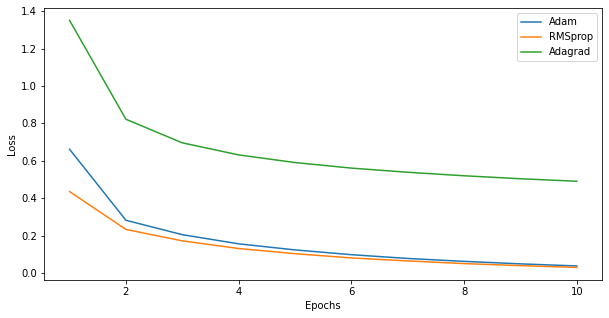

In [ ]:
plt.figure(figsize=(10,5))
for i in range(3):
  plt.plot([i+1 for i in range(n_epochs)], loss_history[i], label=opt_func[i].__name__)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

`Adam` и `RMSprop` в данных условиях доют почти идентичный результат

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0

        return x

In [ ]:
n = CustomReLU()
n(torch.Tensor([[1, 2, -2, -3, 4], [-3, 5, 1, -5, 0]]))

tensor([[1., 2., 0., 0., 4.],
        [0., 5., 1., 0., 0.]])

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
n_epochs = 10
loss_history = [[], [], [], []]
func = [nn.ReLU, CustomReLU]

## YOUR CODE HERE
for i in range(len(func)):
  print(f'{func[i].__name__}')
  fc_net_act = FCNet_act(func[i])
  optimizer = torch.optim.Adam(fc_net_act.parameters(), lr=3e-4)
  for epoch in range(n_epochs):
      epoch_loss = 0
      for images, labels in trainloader: 
          optimizer.zero_grad() 
          outputs = fc_net_act(images) 
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()

      loss_history[i].append(epoch_loss/len(trainloader))
      print(f"Epoch={epoch+1} loss={loss_history[i][epoch]:.4f}")

  print(f'accuracy with {func[i].__name__}', get_accuracy(fc_net_act, testloader))

ReLU
Epoch=1 loss=0.6868
Epoch=2 loss=0.3069
Epoch=3 loss=0.2260
Epoch=4 loss=0.1749
Epoch=5 loss=0.1392
Epoch=6 loss=0.1124
Epoch=7 loss=0.0925
Epoch=8 loss=0.0759
Epoch=9 loss=0.0613
Epoch=10 loss=0.0496
accuracy with ReLU 0.8985
CustomReLU
Epoch=1 loss=0.6855
Epoch=2 loss=0.3017
Epoch=3 loss=0.2218
Epoch=4 loss=0.1731
Epoch=5 loss=0.1392
Epoch=6 loss=0.1115
Epoch=7 loss=0.0905
Epoch=8 loss=0.0755
Epoch=9 loss=0.0605
Epoch=10 loss=0.0492
accuracy with CustomReLU 0.8996


Вот, пожалуйста